In [85]:
import numpy as np
import matplotlib.pyplot as plt
import funkcije_seminar as f

In [86]:
t = f.neodvisna_spremenljivka_t(40);
delta_t = t[1] - t[0];

In [87]:
def analiza1(m1=10, m2=350, k1=260*1000, k2=40*1000, delta1=0.1, delta2= 0.3):
    ''' vrača :
    M, K, delta1, delta2, eigenvalues, eigenvectors, omega1, 
    omega2, omega1D, omega2D, modal_mass_m, modal_stiffness_m'''
    
    M = f.mass_matrix(m1, m2)
    K = f.stiffness_matrix(k1, k2)

    A = np.linalg.inv(M) @ K

    eigenval, eigenvec = np.linalg.eig(A)
    eigenvalues, eigenvectors = f.eig(eigenval, eigenvec)
    omega1 = eigenvalues[0]
    omega2 = eigenvalues[1] 
    omega1D = omega1 * np.sqrt(1 - delta1**2)
    omega2D = omega2 * np.sqrt(1 - delta2**2)
    modal_mass_m, modal_stiffness_m = f.modal_mass_stiffness(eigenvectors, M, K)
    return M, K, delta1, delta2, eigenvalues, eigenvectors, omega1, omega2, omega1D, omega2D, modal_mass_m, modal_stiffness_m

In [88]:
M, K, delta1, delta2, eigenvalues, eigenvectors, omega1, omega2, omega1D, omega2D, modal_mass_m, modal_stiffness_m = analiza1()

In [89]:
t[1]-t[0]

0.001

In [90]:
print("pes")

pes


In [91]:
def izpiseig(eigenvalues, eigenvectors):
    print("eigenvalues")
    #print(np.sqrt(eigenval))
    print(eigenvalues)
    print(" ")
    print("eigenvectors")
    print(eigenvectors)
def izpisMK(M, K):
    print("M")
    print(M)
    print(" ")
    print("K")
    print(K)
def izpisomega(omega1, omega2, omega1D, omega2D):
    print(f'omega1: \t {omega1:.2f} rad/s')
    print(f'omega2: \t {omega2:.2f} rad/s')
    print(f'omega1D: \t {omega1D:.2f} rad/s')
    print(f'omega2D: \t {omega2D:.2f} rad/s')


In [92]:
izpiseig(eigenvalues, eigenvectors)
izpisMK(M, K)
izpisomega(omega1, omega2, omega1D, omega2D)

eigenvalues
[  9.94973207 173.24920937]
 
eigenvectors
[[ 0.13259361  0.9999927 ]
 [ 0.99117049 -0.00382211]]
M
[[ 10.   0.]
 [  0. 350.]]
 
K
[[300000. -40000.]
 [-40000.  40000.]]
omega1: 	 9.95 rad/s
omega2: 	 173.25 rad/s
omega1D: 	 9.90 rad/s
omega2D: 	 165.27 rad/s


# 2

In [93]:
def vzbujanje(hitrost=10, L=0.5, M=M, o=0.1, t=t, delta_t=delta_t):
    '''enote podanih podatkov:
    hitrost: km/h
    L: m
    o: m
    delta_t: s
    
    return vrača:
    ff, Y, Y_v, Y_a, Ft, Modal_Ft 
    '''
    hitrost = hitrost/3.6; # m/s
    ff = 1/(2*L/hitrost); # Hz
    y = np.sin(2 * np.pi * ff * t + 3*np.pi/2) + 1
    t1 = 2/(2*ff);
    t11 = t1 % (t[1] - t[0])
    T1 = t1 - t11
    Y = np.zeros_like(t)
    t_index = np.where(t == T1)
    t2 = 1000 + t_index[0][0] + 1
    Y[1000:t2] = y[0:t2-1000] * o;
    Y_v = np.gradient(Y, delta_t)
    Y_a = np.gradient(Y_v, delta_t)
    B = np.ones((2,1))
    Ft = np.zeros((2, len(t)))
    Ft = - M @ B * Y_a
    Modal_Ft = np.zeros((2, len(t)))
    Modal_Ft = eigenvectors.T @ Ft
    return ff, Y, Y_v, Y_a, Ft, Modal_Ft

In [108]:
ff, Y, Y_v, Y_a, Ft, Modal_Ft = vzbujanje(hitrost=1)
print(f'ff: \t {ff:.2f} Hz')
print(f'Modal_Ft[1]: \t {Modal_Ft[1][1000]}')
1/ff

ff: 	 0.28 Hz
Modal_Ft[1]: 	 -1.3193254847605005


3.5999999999999996

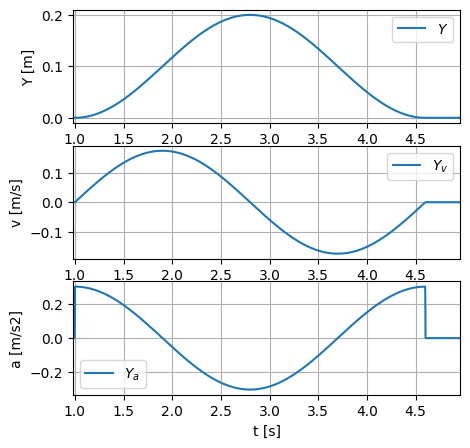

In [112]:
plt.figure(figsize=(5, 5))

plt.subplot(3, 1, 1)
plt.plot(t[:8000], Y[:8000], label=f'$Y$')
plt.xlim(0.98, 1 + 1.1/ff)
plt.ylabel('Y [m]')
plt.xlabel('t [s]')
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t[:8000], Y_v[:8000], label=f'$Y_v$')  
plt.xlim(0.98, 1 + 1.1/ff)
plt.ylabel('v [m/s]')
plt.xlabel('t [s]')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t[:8000], Y_a[:8000], label=f'$Y_a$') 
plt.xlim(0.98, 1 + 1.1/ff)
plt.ylabel('a [m/s2]')
plt.xlabel('t [s]')
plt.legend()
plt.grid()


In [96]:
def konvolucija(t=t, delta_t=0.0001, Modal_Ft=Modal_Ft, omega1=omega1, omega2=omega2, omega1D=omega1D, omega2D=omega2D, delta1=delta1, delta2=delta2):
    '''return: 
    eta
    etaD'''
    g_1 = 1/omega1 * np.sin(omega1 * t)
    g_2 = 1/omega2 * np.sin(omega2 * t)

    g_1d = 1/omega1 * np.exp(-delta1 * omega1 * t) * np.sin(omega1D * t)
    g_2d = 1/omega2 * np.exp(-delta2 * omega2 * t) * np.sin(omega2D * t)
    #1
    eta1 = np.convolve(Modal_Ft[0,:], g_1) * (t[1] - t[0])
    eta1d = np.convolve(Modal_Ft[0,:], g_1d) * (t[1] - t[0])

    #2
    eta2 = np.convolve(Modal_Ft[1,:], g_2) * (t[1] - t[0])
    eta2d = np.convolve(Modal_Ft[1,:], g_2d) * (t[1] - t[0])

    eta = np.zeros((2, 2*len(t) - 1))
    eta[0,:] = eta1
    eta[1,:] = eta2

    etaD = np.zeros((2, 2*len(t) - 1))
    etaD[0,:] = eta1d
    etaD[1,:] = eta2d
    return eta, etaD

In [97]:
eta, etaD = konvolucija()

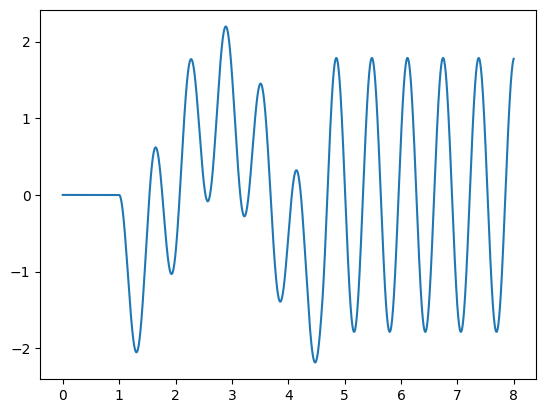

In [98]:
plt.plot(t[:8000], eta[0,:8000], label=f'$\eta_1$')

In [99]:
def rezultat(eta=eta, etaD=etaD, eigenvectors=eigenvectors, t=t, delta_t=0.0001):
    '''return:
    u, uD'''
    z1_1 = eigenvectors[:,0] @ eta
    z1_2 = eigenvectors[:,1] @ eta

    z1_1D = eigenvectors[:,0] @ etaD
    z1_2D = eigenvectors[:,1] @ etaD
    
    x1_1 = z1_1[:len(t)] + Y[:len(t)]
    x1_2 = z1_2[:len(t)] + Y[:len(t)]

    x1_1D = z1_1D[:len(t)] + Y[:len(t)]
    x1_2D = z1_2D[:len(t)] + Y[:len(t)]
    
    v11 = np.gradient(x1_1)/delta_t
    a11 = np.gradient(v11)/delta_t
    v12 = np.gradient(x1_2, delta_t)
    a12 = np.gradient(v12, delta_t)

    v11D = np.gradient(x1_1D, delta_t)
    a11D = np.gradient(v11D, delta_t)
    v12D = np.gradient(x1_2D, delta_t)
    a12D = np.gradient(v12D, delta_t)
    x = np.array([x1_1, x1_2])
    xD = np.array([x1_1D, x1_2D])
    a = np.array([a11, a12])
    aD = np.array([a11D, a12D])
    return x, xD, a, aD

In [100]:
x, xD, a, aD = rezultat()

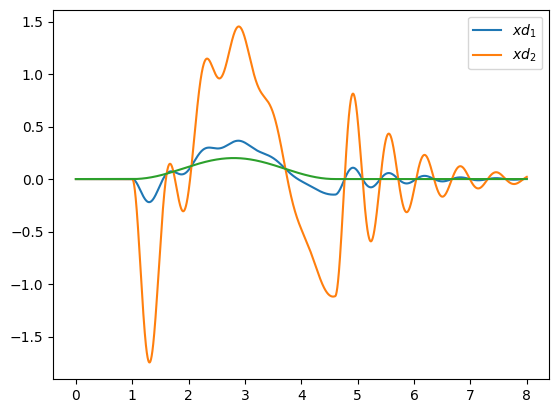

In [120]:
plt.plot(t[:8000], xD[0, :8000], label=f'$xd_1$')
# plt.plot(t[:8000], x[0, :8000], label=f'$x_1$')
plt.plot(t[:8000], xD[1, :8000], label=f'$xd_2$')
# plt.plot(t[:8000], x[1, :8000], label=f'$x_2$')

plt.legend()
plt.plot(t[:8000], Y[:8000], label=f'$x_2$')


In [102]:
v11 = np.gradient(x[0], delta_t)
a11 = np.gradient(v11, delta_t)
v12 = np.gradient(x[0], delta_t)
a12 = np.gradient(v12, delta_t)

v11D = np.gradient(xD[0], delta_t)
a11D = np.gradient(v11D, delta_t)
v12D = np.gradient(xD[1], delta_t)
a12D = np.gradient(v12D, delta_t)

In [103]:
len(a12)

40001

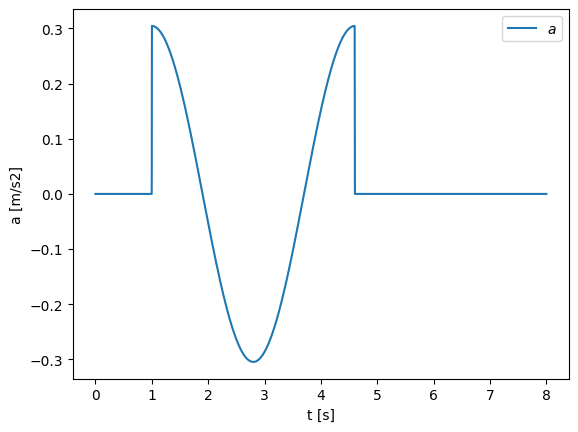

In [119]:
# plt.plot(t[:8000], a[0, :8000], label=f'$a_1$')
# plt.plot(t[:8000], a[1, :8000], label=f'$a_2$')
plt.plot(t[:8000], Y_a[:8000], label=f'$a$')
plt.xlabel('t [s]')
plt.ylabel('a [m/s2]')
plt.legend()

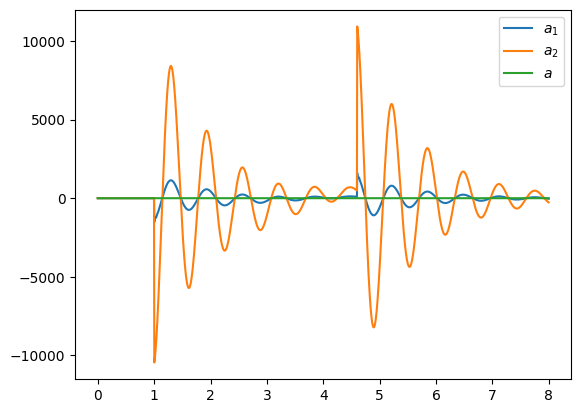

In [115]:
plt.plot(t[:8000], aD[0, :8000], label=f'$a_1$')
plt.plot(t[:8000], aD[1, :8000], label=f'$a_2$')
plt.plot(t[:8000], Y_a[:8000], label=f'$a$')
plt.legend()